In [145]:
"""
Note that the PyTorch nn module provides 3D convolutions for volumes or videos.
For now though we'll stick to 2D examples.

(3D convolution is used for operating on CT scan data in Part 2)
"""

import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3) # 3-channel, 3x3 kernel with 16 out channels
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [146]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [147]:
# Reinit cifar2

import torch
from torchvision import datasets
from torchvision import transforms
data_path = "../data/cifar-10/"


class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

# Add to dataset transforms
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)


transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)
   

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [
    (img, label_map[label])
    for img, label in transformed_cifar10
    if label in [0, 2]
]


cifar2_val = [
    (img, label_map[label])
    for img, label in transformed_cifar10_val
    if label in [0, 2]
]

In [148]:
# Convolution i/o example

img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) # requires dimensions B x C x H x W
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Bird after convolution:


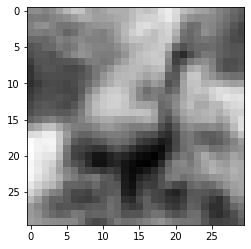

In [149]:
import matplotlib.pyplot as plt

print("Bird after convolution:")

plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [150]:
"""
Downsampling is common in multi-layer convolution, to ensure content 
initially larger than our kernels can be captured. This can be done using pooling
or specially strided convolutions. We will focus on maxpooling, which has until now
proved most effective.
"""

pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [151]:
# A convolutional model (basic CNN)

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # End with fully connected layers
    # Flatten required to transform the 8x8 image up to this point into 512x1 vector
    # We can (and used to have to) forego this by subclassing nn.Module as below,
    # which means abandoning the use of nn.Sequential
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=32, bias=True)
  (8): Tanh()
  (9): Linear(in_features=32, out_features=2, bias=True)
)

In [152]:
# Quick parameter count

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Alternative approach to Flatten: subclassing nn.Module.

This is also often required for other operations which the provided modules don't supply.

In [153]:
class Net(nn.Module):
    
    """
    The Net class is equivalent to the nn.Sequential model
    we built earlier in terms of submodules; but by writing
    the forward function explicitly, we can manipulate the
    output of self.pool3 directly and call view on it to turn
    it into a B × N vector (see out.view in the forward() function.
    This is now allowed in an nn.Sequential model, for reasons.
    
    https://github.com/pytorch/pytorch/issues/2486
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [154]:
# The functional API (torch.nn.functional) provides counterparts for nn.Modules
# which have no internal state (e.g. parameters). This means modules which do not
# require backprop can be placed in the forward() function

import torch.nn.functional as F

class Net(nn.Module):
    
    """
    A version of the prior Net model utilising the Functional API.
    
    It doesn't matter if we don't use it, but it can make the boilerplate
    more concise as below.
    """
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        # tanh as a general-purpose scientific function remains in the torch namespaces
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [155]:
# Does it run?

model = Net()
model(img.unsqueeze(0))

tensor([[ 0.1390, -0.0421]], grad_fn=<AddmmBackward>)

In [156]:
# Training loop definition

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(),
                epoch,
                loss_train / len(train_loader)
            ))

In [157]:
# Dataloader init and run

import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2020-12-29 15:43:34.736920 Epoch 1, Training loss 0.5616403184119304
2020-12-29 15:43:42.875628 Epoch 10, Training loss 0.33541767545946083
2020-12-29 15:43:51.848313 Epoch 20, Training loss 0.2900612192928411
2020-12-29 15:44:00.721711 Epoch 30, Training loss 0.2631163894181039
2020-12-29 15:44:09.798966 Epoch 40, Training loss 0.24199788241534476
2020-12-29 15:44:18.840328 Epoch 50, Training loss 0.22244340020000555
2020-12-29 15:44:27.717401 Epoch 60, Training loss 0.20669520888358925
2020-12-29 15:44:36.831292 Epoch 70, Training loss 0.19036743282132848
2020-12-29 15:44:45.897086 Epoch 80, Training loss 0.1749586113698923
2020-12-29 15:44:54.959023 Epoch 90, Training loss 0.16365510087673832
2020-12-29 15:45:03.860084 Epoch 100, Training loss 0.14953561459377313


In [158]:
# Measuring accuracy on validation set

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


In [159]:
# Saving and loading the model

torch.save(model.state_dict(), data_path + "birds_vs_airplanes_v1.pt")

In [160]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes_v1.pt"))

loaded_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [161]:
# Training on GPU requires specification of which device you're using,
# And casting the model to it.

# NOTE: CUDA installation was messed up when this was written. TODO: run this on a working
# GPU machine at some point.

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
    
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Training on device cpu.


In [162]:
train_loader = torch.utils.data.DataLoader(
    cifar2,
    batch_size=64,
    shuffle=True
)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 15:45:05.681524 Epoch 1, Training loss 0.5802819147990768
2020-12-29 15:45:13.931716 Epoch 10, Training loss 0.33547416917837347
2020-12-29 15:45:23.256881 Epoch 20, Training loss 0.2961105896029503
2020-12-29 15:45:32.521926 Epoch 30, Training loss 0.2680801980814357
2020-12-29 15:45:41.945774 Epoch 40, Training loss 0.24752296469393809
2020-12-29 15:45:51.100881 Epoch 50, Training loss 0.23162111364732121
2020-12-29 15:46:00.394841 Epoch 60, Training loss 0.21928325765261983
2020-12-29 15:46:09.608865 Epoch 70, Training loss 0.20406374311561037
2020-12-29 15:46:18.737461 Epoch 80, Training loss 0.19069370186063134
2020-12-29 15:46:28.037005 Epoch 90, Training loss 0.18079545415320974
2020-12-29 15:46:37.491792 Epoch 100, Training loss 0.1666493516913645


In [163]:
"""
We have the option of casting a model trained on a certain device to another device
before saving its state dict, but it's more concise (particularly if we're not sure
what kind of device we'll next use it on), if we pass the current device used as map_location
when later loading a saved state_dict.
"""

loaded_model = Net().to(device=device)
loaded_model.load_state_dict(
    torch.load(
        data_path + "birds_vs_airplanes_v1.pt",
        map_location=device # Here
    )
)

<All keys matched successfully>

In [164]:
"""
Changing the width of a NN is easy and can be parameterised as follows.
"""

class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 //2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [165]:
"""
The numbers specifying channels and features for each layer are directly related to
the number of parameters in a model; all other things being equal, they increase the
capacity of the model.

The greater the capacity, the more variability in the inputs the model will be able to
manage; but at the same time, the more likely overfitting will be, since the model can
use a greater number of parameters to memorize unessential aspects of the input.
"""

model = NetWidth()
sum(p.numel() for p in model.parameters())

38386

In [166]:
"""
Training loop with L2 regularization (weight decay)

NOTE: PyTorch's SGD optimizer has a parameter weight_decay which
performs L2 regularization during the model updates.
"""


def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                    datetime.datetime.now(),
                    epoch,
                    loss_train / len(train_loader)
                )
            )

In [167]:
"""
Example network with dropout

NOTE: dropout is normally active during training, while during the evaluation of a
trained model in production, dropout is bypassed or, equivalently, assigned a probability
equal to zero. This is controlled through the train property of the Dropout
module.
"""

class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = slef.conv1_dropout(out)
        out =  F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetDropout()
model.train() # Dropout modules active
model.eval() # Dropout modules deactivated

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [168]:
"""
Example network with batch norm

Normalization is still done in eval mode, but the batch norm modules will stop refining
their approximations of mean and stddev, based on inputs to the network, in order to do it.
Instead these are frozen.
"""

class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = NetBatchNorm()
model.train() # Outputs depend on the statistics of other inputs presented to the model
model.eval() # Normalization parameters are fixed (running estimates of mean and stddev)

NetBatchNorm(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [169]:
"""
Example network with a skip connection
"""

class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
        kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        # Identity mapping
        # Below, output of the first 2 layers is added to the input of the following 
        # layers, this will encourage larger gradients in these later layers
        # and prevent them from vanishing.
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [170]:
"""
Defining a very deep model dynamically with a for loop
"""

# Create a module subclass which provides the computation for one network block

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        
        # Bias is perhaps unnecessarily removed, as it would be cancelled out by batch norm
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        # Kaiming initialization is used to mirror ResNet paper (by Kaiming He)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # Define a sequential section of n ResBlocks
        # (notice this is using unpacking within nn.Sequential)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # look how elegant 👏👏👏
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## Chapter exercises

In [185]:
# 1

class ResBlockLargeKernel(nn.Module):
    def __init__(self, n_chans):
        super(ResBlockLargeKernel, self).__init__()
        
        # Bias is perhaps unnecessarily removed, as it would be cancelled out by batch norm
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=5, padding=2, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        # Kaiming initialization is used to mirror ResNet paper (by Kaiming He)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    

class NetResDeepLargeKernel(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        # Define a sequential section of n ResBlocks
        # (notice this is using unpacking within nn.Sequential)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlockLargeKernel(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # look how elegant 👏👏👏
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [186]:
old_model = NetResDeep()
new_model = NetResDeepLargeKernel()

print(f"Num parameters of model with 3x3 kernels: {sum(p.numel() for p in old_model.parameters())}")

print(f"Num parameters of model with 5x5 kernels: {sum(p.numel() for p in new_model.parameters())}")

Num parameters of model with 3x3 kernels: 75810
Num parameters of model with 5x5 kernels: 93730


In [182]:
# Train and validate both versions (question b)

# Larger learning rate required due to network depth
optimizer = optim.SGD(old_model.parameters(), lr=3e-3)

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = old_model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 17:09:50.301053 Epoch 1, Training loss 0.5202728854432986
2020-12-29 17:11:05.996886 Epoch 10, Training loss 0.25052246290027713
2020-12-29 17:12:30.083811 Epoch 20, Training loss 0.16439602130157932
2020-12-29 17:13:54.200700 Epoch 30, Training loss 0.11668118172485357
2020-12-29 17:15:18.615371 Epoch 40, Training loss 0.06719226470205245
2020-12-29 17:16:44.518801 Epoch 50, Training loss 0.025426735250267445
2020-12-29 17:18:13.273122 Epoch 60, Training loss 0.01360794933435691
2020-12-29 17:19:37.763340 Epoch 70, Training loss 0.008508479982691632
2020-12-29 17:21:02.375609 Epoch 80, Training loss 0.024431639221929917
2020-12-29 17:22:26.351341 Epoch 90, Training loss 0.006529858320281147
2020-12-29 17:23:50.105568 Epoch 100, Training loss 0.0046856269884741845


In [183]:
# Valiation

validate(old_model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.87


In [187]:
# For new model

optimizer = optim.SGD(new_model.parameters(), lr=3e-3)

# Batch size has to be reduced
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = new_model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 17:55:16.457646 Epoch 1, Training loss 0.49891238645383507
2020-12-29 17:57:23.593857 Epoch 10, Training loss 0.24797692894935608
2020-12-29 17:59:44.538122 Epoch 20, Training loss 0.15284288824079142
2020-12-29 18:02:05.006397 Epoch 30, Training loss 0.08948038256234804
2020-12-29 18:04:24.977348 Epoch 40, Training loss 0.024353099316595846
2020-12-29 18:06:44.196659 Epoch 50, Training loss 0.008615106650462053
2020-12-29 18:09:03.822550 Epoch 60, Training loss 0.007486367485468175
2020-12-29 18:11:23.168648 Epoch 70, Training loss 0.0031441627763609172
2020-12-29 18:13:42.782172 Epoch 80, Training loss 0.002061145521765634
2020-12-29 18:16:02.164690 Epoch 90, Training loss 0.011530046756112368
2020-12-29 18:18:26.842340 Epoch 100, Training loss 0.006720295821755508


In [188]:
validate(new_model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.89


Bigger kernels have made overfitting worse! Makes sense, as for images of this size, we're probably learning fewer lower level features which generally demark the differences between birds and planes. Instead memorizing more features of the specific images in the training set.

I suspect with a kernel of size 1 x 3, the kind of features you're able to detect would reduice to e.g. horizontal edges (vertical edges might be a challenge with no surrounding infromation) or extremely small features which appear as dots. But let's see how the model behaves...

In [214]:
class ResBlockOneByThree(nn.Module):
    def __init__(self, n_chans):
        super(ResBlockOneByThree, self).__init__()
        
        # Bias is perhaps unnecessarily removed, as it would be cancelled out by batch norm
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        
        # Kaiming initialization is used to mirror ResNet paper (by Kaiming He)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    

class NetResDeepOneByThree(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=(1, 3), padding=(0, 1))
        # Define a sequential section of n ResBlocks
        # (notice this is using unpacking within nn.Sequential)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlockOneByThree(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out) # look how elegant 👏👏👏
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [215]:
one_by_three_model = NetResDeepOneByThree()

In [216]:
# Train and eval

optimizer = optim.SGD(one_by_three_model.parameters(), lr=3e-3)

# Batch size has to be reduced
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = one_by_three_model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-12-29 18:46:08.264488 Epoch 1, Training loss 0.48734024603655385
2020-12-29 18:47:05.159004 Epoch 10, Training loss 0.2887533436155623
2020-12-29 18:48:08.751542 Epoch 20, Training loss 0.19536876175433968
2020-12-29 18:49:11.647584 Epoch 30, Training loss 0.14445689989692845
2020-12-29 18:50:14.593449 Epoch 40, Training loss 0.08576493622485999
2020-12-29 18:51:17.477788 Epoch 50, Training loss 0.05021787306685357
2020-12-29 18:52:20.504856 Epoch 60, Training loss 0.02959425278767279
2020-12-29 18:53:23.333117 Epoch 70, Training loss 0.015177985424899561
2020-12-29 18:54:26.456631 Epoch 80, Training loss 0.009661379759644817
2020-12-29 18:55:29.561084 Epoch 90, Training loss 0.010214845245039671
2020-12-29 18:56:32.508391 Epoch 100, Training loss 0.018478320112932402


In [217]:
validate(one_by_three_model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 0.88


Huh, no great change. Overfitting, overfitting, overfitting.